In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
%matplotlib inline

First we will load the data and have an initial idea how the data looks like!

In [2]:
df = pd.read_csv('data_for_student_case.csv')
print(df.shape)
print("Settled transactions: " + str(df[df['simple_journal'] == 'Settled'].count()["simple_journal"]))
print("Fraud transactions: " + str(df[df['simple_journal'] == 'Chargeback'].count()["simple_journal"]))

(290382, 17)
Settled transactions: 236691
Fraud transactions: 345


### Data pre-processing
Then we will do some basic data pre-processing work:
- Drop refused transactions
- Convert string to datetime
- Convert creationdateday to day
- Convert currency to same unit (British Pounds) 

In [4]:
# Convert currency to British Pounds
def conv_curr_2_GBP (currencycode, amount):
    rates = {'NZD':0.46, 'AUD':0.49, 'GBP':1, 'MXN':0.04, 'SEK':0.08}
    rate = rates[currencycode]
    return rate*amount

def preprocessing(df):
    # Drop refused transaction
    df = df[df['simple_journal'] != 'Refused']
    
    df = df.assign(creationdate_day = pd.Timestamp('2019-01-05'))
    df = df.assign(shopper_issue_country = 0) # label 1: same, 0 : different
    for index, row in df.iterrows():
        df.at[index, 'amount'] = conv_curr_2_GBP(row['currencycode'], row['amount'])
        df.at[index, 'bookingdate'] = pd.to_datetime(row['bookingdate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
        creationdate = pd.to_datetime(row['creationdate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
        df.at[index, 'creationdate'] = creationdate
        df.at[index, 'creationdate_day'] = creationdate.strftime("%Y-%m-%d")
        if (row['issuercountrycode'] == row['shoppercountrycode']):
            df.at[index, 'shopper_issue_country'] = 0
        else:
            df.at[index, 'shopper_issue_country'] = 1
            
    return df

df = preprocessing(df)

### Data processing
We add several new features we thought that might help to improve the classification:
- past_fraud_ip: Number of history fraudulent transactions from the same IP address
- past_fraud_card: Number of history fraudulent transactions from the same credit card
- number_same_day: Total number of transactions on the same day up to this transaction
- amount_same_day: Total amount spent on the same day up to this transaction
- shopper_issue_country: matching between shoppercountrycode and issuecountrycode

In [5]:
def grouped_card_feature(df):
    df = df.assign(past_fraud_card = 0)
    df = df.assign(number_same_day = 0)
    df = df.assign(amount_same_day = 0)

    grouped_card = df.groupby("card_id")
    
    for index, row in df.iterrows():
        grouped_same_card = grouped_card.get_group(row['card_id'])
        grouped_same_card_fraud = grouped_same_card.loc[grouped_same_card['simple_journal'] == 'Chargeback']
        grouped_same_card_fraud_before = grouped_same_card_fraud.loc[grouped_same_card_fraud['creationdate'] < row['creationdate']]
        df.at[index,'past_fraud_card'] = len(grouped_same_card_fraud_before)
        
        tran_same_day = grouped_same_card[(grouped_same_card['creationdate'] < row['creationdate']) & (grouped_same_card['creationdate_day'] == row['creationdate_day'])]
        df.at[index, 'number_same_day'] = len(tran_same_day)
        df.at[index, 'amount_same_day'] = tran_same_day['amount'].sum()

    return df

def grouped_ip_feature(df):
    df = df.assign(past_fraud_ip = 0)
    
    grouped_ip = df.groupby("ip_id")

    for index, row in df.iterrows():
        grouped_same_ip = grouped_ip.get_group(row['ip_id'])
        grouped_same_ip_fraud = grouped_same_ip.loc[grouped_same_ip['simple_journal'] == 'Chargeback']
        grouped_same_ip_fraud_before = grouped_same_ip_fraud.loc[grouped_same_ip_fraud['creationdate'] < row['creationdate']]
        df.at[index,'past_fraud_ip'] = len(grouped_same_ip_fraud_before)
    
    return df

df = grouped_card_feature(df)
df = grouped_ip_feature(df)
benign_data = df[df['simple_journal'] == 'Settled']
fraud_data = df[df['simple_journal'] == 'Chargeback']
df.to_csv("processed.csv", encoding='utf-8')

### Visualize the data
Visualize the money attribute

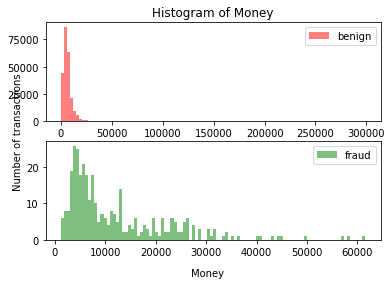

In [151]:
def show_money(benign_data, fraud_data):
    f, axarr = plt.subplots(2)
    kwargs = dict(alpha=0.5, bins=100)
    axarr[0].hist(benign_data['amount'], **kwargs, color='r', label='benign')
    axarr[0].legend()
    axarr[1].hist(fraud_data['amount'], **kwargs, color='g', label='fraud')
    axarr[1].legend()
    f.text(0.5, 0.01, 'Money', ha='center', va='center')
    f.text(0.06, 0.5, 'Number of transactions', ha='center', va='center', rotation='vertical')
    axarr[0].set_title("Histogram of Money")
    plt.show()

show_money(benign_data, fraud_data)

Visualize country attribute

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


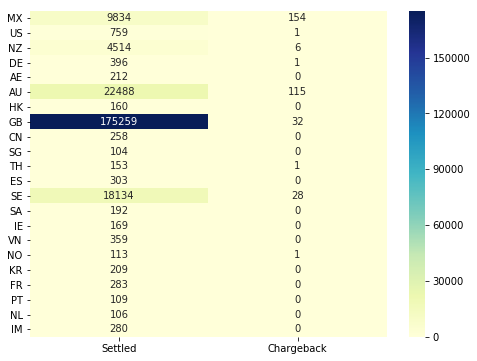

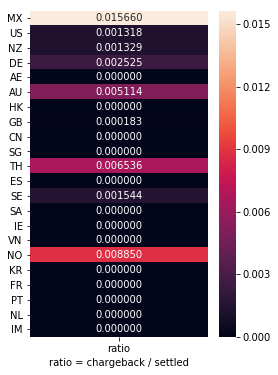

In [145]:
def show_country(df):
    country_list = df['shoppercountrycode'].unique()
    result_list = ['Settled', 'Chargeback', 'ratio']
    df_count = pd.DataFrame(index=country_list, columns=result_list, dtype='float64') # dataframe store counts
    count = df.groupby(['shoppercountrycode','simple_journal']).size() # groupby count 

    # Count
    for country in country_list:
        for result in result_list:
            if (country, result) in count:
                df_count.at[country, result] = int(count[country][result])
            else:
                df_count.at[country, result] = int(0)

            df_count.at[country, 'ratio'] = df_count.at[country, 'Chargeback'] / df_count.at[country, 'Settled']


    # Drop countries which has less than 100 records 
    df_count = df_count.drop(df_count[df_count['Settled'] + df_count['Chargeback'] < 100].index)

    # Plot heatmap for country count
    plt.figure(figsize=(8,6))
    sns.heatmap(df_count[['Settled', 'Chargeback']], annot=True, fmt='.0f',cmap="YlGnBu")

    # Plot heatmap for ratio
    plt.figure(figsize=(4,6))
    sns.heatmap(df_count['ratio'].to_frame(), annot=True, fmt='.6f')
    plt.xlabel("ratio = chargeback / settled")

show_country(df)

We feel the matching between shoppercountrycode and issuercountrycode is related to the classification task, so we visualize it to see the result

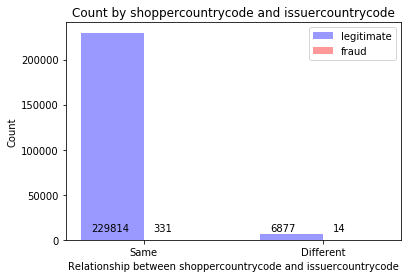

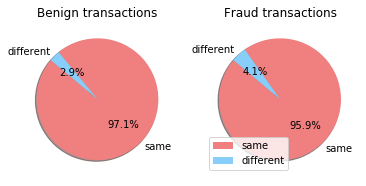

In [146]:
def show_shopper_issue_country(benign_data, fraud_data):
    shopper_issue_same_benign = len(benign_data.loc[benign_data['shoppercountrycode'] == benign_data['issuercountrycode']])
    shopper_issue_diff_benign = len(benign_data.loc[benign_data['shoppercountrycode'] != benign_data['issuercountrycode']])
    shopper_issue_same_fraud = len(fraud_data.loc[fraud_data['shoppercountrycode'] == fraud_data['issuercountrycode']])
    shopper_issue_diff_fraud = len(fraud_data.loc[fraud_data['shoppercountrycode'] != fraud_data['issuercountrycode']])

    shopper_issue_benign = (shopper_issue_same_benign, shopper_issue_diff_benign)
    shopper_issue_fraud = (shopper_issue_same_fraud, shopper_issue_diff_fraud)

    # Bar chart
    fig, ax = plt.subplots()
    index = np.arange(2)
    bar_width = 0.35

    rects1 = ax.bar(index, shopper_issue_benign, bar_width,
                    alpha=0.4, color='b', label='legitimate')

    rects2 = ax.bar(index + bar_width, shopper_issue_fraud, bar_width,
                    alpha=0.4, color='r',label='fraud')

    ax.set_xlabel('Relationship between shoppercountrycode and issuercountrycode')
    ax.set_ylabel('Count')
    ax.set_title('Count by shoppercountrycode and issuercountrycode')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(('Same', 'Different'))
    ax.legend()
    # display value 
    for i, v in enumerate(shopper_issue_benign):
        ax.text(i-.12, v/shopper_issue_benign[i] + 10000, str(shopper_issue_benign[i]), color='black')
    for i, v in enumerate(shopper_issue_fraud):
        ax.text(i-.12 + bar_width, v/shopper_issue_fraud[i] + 10000, str(shopper_issue_fraud[i]), color='black')
    plt.show()
    
    # Pie chart
    labels = ['same','different']
    colors = ['lightcoral', 'lightskyblue']

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.pie(shopper_issue_benign, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
    ax1.set_title("Benign transactions")
    ax2.pie(shopper_issue_fraud, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
    ax2.set_title("Fraud transactions")
    ax2.legend()
    plt.show()

show_shopper_issue_country(benign_data, fraud_data)

Visualize the shopperinteraction attribute (Ecommerce or ContAuth)

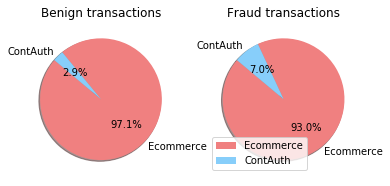

In [147]:
def show_shopperinteraction(benign_data, fraud_data):
    ecommerce_benign = len(benign_data.loc[benign_data['shopperinteraction'] == 'Ecommerce'])
    contAuth_benign = len(benign_data.loc[benign_data['shopperinteraction'] == 'ContAuth'])
    ecommerce_fraud = len(fraud_data.loc[fraud_data['shopperinteraction'] == 'Ecommerce'])
    contAuth_fraud = len(fraud_data.loc[fraud_data['shopperinteraction'] == 'ContAuth'])

    labels = ['Ecommerce','ContAuth']
    colors = ['lightcoral', 'lightskyblue']

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.pie((ecommerce_benign, contAuth_benign), labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
    ax1.set_title("Benign transactions")
    ax2.pie((ecommerce_fraud, contAuth_fraud), labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
    ax2.set_title("Fraud transactions")
    ax2.legend()
    plt.show()

show_shopperinteraction(benign_data, fraud_data)

Visualize past_fraud_card: Number of history fraudulent transactions from the same credit card

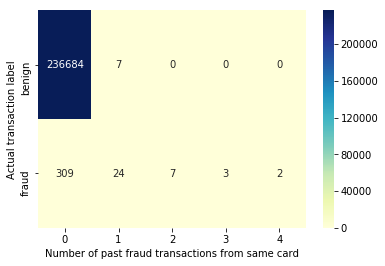

In [162]:
def show_past_fraud_card(benign_data, fraud_data):
    column_size = max(benign_data['past_fraud_card'].max() + 1, fraud_data['past_fraud_card'].max() + 1)
    past_fraud_card_count = pd.DataFrame(index=['benign', 'fraud'], columns = range(0, column_size), dtype='int64')
    for i in range(0, column_size):
        past_fraud_card_count.at['benign', i] = len(benign_data.loc[benign_data['past_fraud_card'] == i])
        past_fraud_card_count.at['fraud', i] = len(fraud_data.loc[fraud_data['past_fraud_card'] == i])

    sns.heatmap(past_fraud_card_count, annot=True, fmt='.0f',cmap="YlGnBu")
    plt.xlabel("Number of past fraud transactions from same card")
    plt.ylabel("Actual transaction label")
    plt.show()

show_past_fraud_card(benign_data, fraud_data)

Visualize past_fraud_ip: Number of history fraudulent transactions from the same IP address

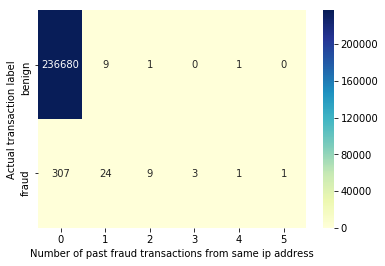

In [163]:
def show_past_fraud_ip(benign_data, fraud_data):
    column_size = max(benign_data['past_fraud_ip'].max() + 1, fraud_data['past_fraud_ip'].max() + 1)
    past_fraud_ip_count = pd.DataFrame(index=['benign', 'fraud'], columns = range(0, column_size), dtype='int64')
    for i in range(0, column_size):
        past_fraud_ip_count.at['benign', i] = len(benign_data.loc[benign_data['past_fraud_ip'] == i])
        past_fraud_ip_count.at['fraud', i] = len(fraud_data.loc[fraud_data['past_fraud_ip'] == i])

    sns.heatmap(past_fraud_ip_count, annot=True, fmt='.0f',cmap="YlGnBu")
    plt.xlabel("Number of past fraud transactions from same ip address")
    plt.ylabel("Actual transaction label")
    plt.show()

show_past_fraud_ip(benign_data, fraud_data)

Visualize number_same_day: Total number of transactions on the same day up to this transaction

              0       1      2     3     4     5     6     7     8     9   \
benign  233753.0  2349.0  236.0  89.0  51.0  39.0  32.0  24.0  23.0  18.0   
fraud      309.0    22.0    9.0   3.0   2.0   0.0   0.0   0.0   0.0   0.0   

       ...    16   17   18   19   20   21   22   23   24   25  
benign ...   5.0  5.0  2.0  2.0  2.0  2.0  2.0  1.0  1.0  1.0  
fraud  ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 26 columns]


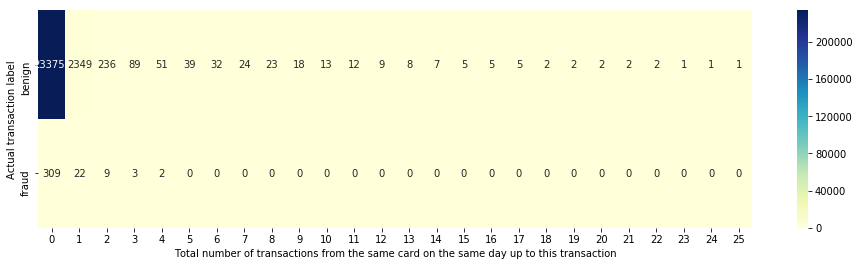

In [150]:
def show_number_same_day(benign_data, fraud_data):
    column_size = max(benign_data['number_same_day'].max() + 1, fraud_data['number_same_day'].max() + 1)
    number_same_day_count = pd.DataFrame(index=['benign', 'fraud'], columns = range(0, column_size), dtype='int64')
    for i in range(0, column_size):
        number_same_day_count.at['benign', i] = len(benign_data.loc[benign_data['number_same_day'] == i])
        number_same_day_count.at['fraud', i] = len(fraud_data.loc[fraud_data['number_same_day'] == i])

    print(number_same_day_count)

    plt.figure(figsize=(16,4))
    sns.heatmap(number_same_day_count, annot=True, fmt='.0f',cmap="YlGnBu")
    plt.xlabel("Total number of transactions from the same card on the same day up to this transaction")
    plt.ylabel("Actual transaction label")
    plt.show()

show_number_same_day(benign_data, fraud_data)

Visualize amount_same_day: Total amount spent on the same day up to this transaction

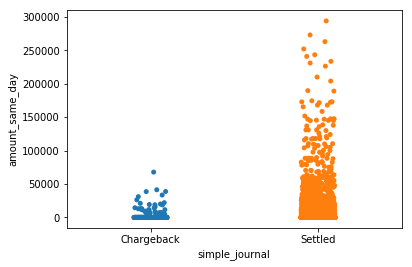

In [161]:
def show_amount_same_day(df):
    sns.stripplot(x='simple_journal', y='amount_same_day', data=df)  
    plt.show()
    
show_amount_same_day(df)